# __Homework 2 - Instagram Profiles & Posts__

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import datatable as dt # probably needed !pip install datatable
import re
import os
import statistics
from math import pi, floor, log10, ceil
from scipy.stats.stats import pearsonr


SAMPLE_SIZE = 10000

%matplotlib inline
import matplotlib.pyplot as plt
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install pyarrow

***

## __Preprocessing__

***

In [3]:
class Dataset:
    def __init__(self, file:str):
        self.file_name : str = file
        self.types : dict = self.load_types()
        self.df : pd.DataFrame = None
        
    def name(self):
        return re.search(r'\/([\w\d]*)\.csv',self.file_name).group(1)
    
    def __types_file__(self):
        return 'types/' + self.name() +'.npy'
        
    def save_types(self):
        np.save(self.__types_file__(), self.types)
        
    def load_types(self):
        if os.path.isfile(self.__types_file__()):
            self.types = np.load(self.__types_file__(),allow_pickle='TRUE').item()
            return self.types
        return None
    
    def col(self,columns:list, index=True,**dt_params)->pd.DataFrame:
        """Loads some columns of the dataframe out of the whole csv file
        
        :param columns: a list of the desired columns
        :type columns: list
        :param index: if True loads also the 'sid' column as the index
        :type index: bool
        :param **pd_params: any other params for pd.read_csv(...)
        :rtype: pd.DataFrame
        """
        col_list = columns
        if index==True:
            col_list.append('sid')
        d = dt.fread(self.file_name,
                           columns=set(col_list),
                           sep='\t',
                            **dt_params)
        if index == True:
            d.key = 'sid'
        elif index:
            d.key = index
        d = d.to_pandas().astype({k:v for k,v in self.types.items() if k in d.names})
        if 'cts' in col_list:
            d['cts'] = pd.to_datetime(d['cts'])
        return d

datasets = [
    Dataset(file='instagram-dataset/instagram_profiles.csv'), 
    Dataset(file='instagram-dataset/instagram_locations.csv'), 
    Dataset(file='instagram-dataset/instagram_posts.csv')
]
profiles, locations, posts = datasets

Columns and inferred types from descrption 
TODO DESCRIBE MORE

In [4]:
profiles.types = {
#     'sid' : 'Int64',
    'profile_id' : 'Int64',
    'profile_name' : pd.StringDtype(storage='pyarrow'),
    'firstname_lastname' : pd.StringDtype(storage='pyarrow'),
    'description' : pd.StringDtype(storage='pyarrow'),
    'following' : 'Int64',
    'followers' : 'Int64',
    'n_posts' : 'Int64',
    'url' : pd.StringDtype(storage='pyarrow'),
#     'cts' : pd.DatetimeTZDtype(tz='UTC'), #obtained through parse_dates=['cts']
    'is_business_account' : pd.BooleanDtype()
}
posts.types = {
#     'sid' : 'Int64', # gives an error, maybe because it's the index?
    'sid_profile' : 'Int64',
    'post_id' : pd.StringDtype(storage='pyarrow'),
    'profile_id' : 'Int64',
    'location_id' : 'Int64',
    'description' : pd.StringDtype(storage='pyarrow'),
    'post_type' : pd.CategoricalDtype(categories=[1,2,3]),
    'numbr_likes' : 'Int64',
    'number_comments' : 'Int64'
}
locations.types = {
#     'sid' : 'Int64', # gives an error, maybe because it's the index?
    'id' : 'Int64',
    'name' : pd.StringDtype(storage='pyarrow'),
    'street' : pd.StringDtype(storage='pyarrow'),
    'zip' : pd.StringDtype(storage='pyarrow'),
    'city' : pd.StringDtype(storage='pyarrow'),
    'region' : pd.StringDtype(storage='pyarrow'),
    'cd' : pd.CategoricalDtype(),
    'phone' : pd.StringDtype(storage='pyarrow'),
    'aj_exact_city_match' : pd.BooleanDtype(),
    'aj_exact_country_match' : pd.BooleanDtype(),
    'blurb' : pd.StringDtype(storage='pyarrow'),
    'dir_city_id' : pd.StringDtype(storage='pyarrow'),
    'dir_city_name' : pd.StringDtype(storage='pyarrow'),
    'dir_city_slug' : pd.StringDtype(storage='pyarrow'),
    'dir_country_id' : pd.CategoricalDtype(),
    'dir_country_name' : pd.CategoricalDtype(),
    'lat' : pd.Float32Dtype(),
    'lng' : pd.Float32Dtype(),
    'primary_alias_on_fb' : pd.StringDtype(storage='pyarrow'),
    'slug' : pd.StringDtype(storage='pyarrow'),
    'website' : pd.StringDtype(storage='pyarrow'),
}

In [5]:
def get_types(signed=True, unsigned=True, custom=[]):
    '''Returns a pandas dataframe containing the boundaries of each integer dtype'''
    # based on https://stackoverflow.com/a/57894540/9419492
    pd_types = custom
    if signed:
        pd_types += [pd.Int8Dtype() ,pd.Int16Dtype() ,pd.Int32Dtype(), pd.Int64Dtype()]
    if unsigned:
        pd_types += [pd.UInt8Dtype() ,pd.UInt16Dtype(), pd.UInt32Dtype(), pd.UInt64Dtype()]
    type_df = pd.DataFrame(data=pd_types, columns=['pd_type'])
    type_df['np_type'] = type_df['pd_type'].apply(lambda t: t.numpy_dtype)
    type_df['min_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).min)
    type_df['max_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).max)
    type_df['allow_negatives'] = type_df['min_value'] < 0
    type_df['size'] = type_df['np_type'].apply(lambda row: row.itemsize)
    type_df.sort_values(by=['size', 'allow_negatives'], inplace=True)
    return type_df.reset_index(drop=True)
def downcast_int(file_path, column:str, chunksize=10000, delimiter=',', signed=True, unsigned=True):
    '''Assigns the smallest possible dtype to an integer column of a csv'''
    types = get_types(signed, unsigned)
    negatives = False
    print(delimiter)
    for chunk in pd.read_csv(file_path, 
                             usecols=[column],
                             delimiter=delimiter,
                             chunksize=chunksize):
        M = chunk[column].max()
        m = chunk[column].min()
        if not signed and not negatives and m < 0 :
            types = types[types['allow_negatives']] # removes unsigned rows
            negatives = True
        if m < types['min_value'].iloc[0]:
            types = types[types['min_value'] < m]
        if M > types['max_value'].iloc[0]:
            types = types[types['max_value'] > M]
        if len(types) == 1:
            print('early stop')
            break
    return types['pd_type'].iloc[0]

def optimize_cols(file, int_cols, delimiter=',', signed=True, unsigned=True):
    out = dict()
    for col in int_cols:
        out[col] = downcast_int(file, col, delimiter=delimiter, signed=signed, unsigned=unsigned)
    return out

Optimize types

In [6]:
for ds in datasets:
    if not ds.load_types():
        int_cols = [k for k,v in ds.types.items() if v == 'Int64']
        print(int_cols)
        ds.types.update(optimize_cols(ds.file_name, int_cols, delimiter='\t'))
        print(f'Optimized {len(int_cols)} types for {ds.name()}')
    ds.save_types()

for ds in datasets:
    ds.df = pd.read_csv(ds.file_name, dtype=ds.types, index_col='sid', delimiter='\t', parse_dates=['cts'], nrows=SAMPLE_SIZE)
    avg_mem_unoptimized = pd.read_csv(ds.file_name, index_col='sid', delimiter='\t', nrows=SAMPLE_SIZE).memory_usage(deep=True).sum()/SAMPLE_SIZE
    avg_mem_optimized = ds.df.memory_usage(deep=True).sum()/SAMPLE_SIZE
    print(f'{ds.name().ljust(19)} mean optimized memory usage per entry:  {round(avg_mem_optimized):3} B vs {round(avg_mem_unoptimized):4} B  : {round(avg_mem_optimized/avg_mem_unoptimized*100,2):5}%') 

instagram_profiles  mean optimized memory usage per entry:  150 B vs  542 B  : 27.71%
instagram_locations mean optimized memory usage per entry:  272 B vs 1117 B  : 24.34%
instagram_posts     mean optimized memory usage per entry:  277 B vs  752 B  : 36.89%


## RQ1 - EDA
Andrea

#### Profiles 
| Field | Description | Type |
|---|---|---|
| SID | Sequence ID | `int` |
| profile_id | Instagrams ID | `int `|
| profile_name | profile name | `string` |
| firstname_lastname | firstname lastname | `string` |
| description | May contain '\n' | `string` |
| following | Number of following profile at the moment it was visited | `int` |
| followers | Number of followers at the moment it was visited | `int` |
| n_posts | Number of posts at the moment it was visited | `int` |
| url | Url in profile description | `string` |
| cts | Timestamp when the profile was visited | `datetime` |
| is_business_account | Boolean flag if that profile was makred by the owner as business account | `bool` |

#### Locations

| Field | Description | Type |
|---|---|---|
| SID | Sequence ID | `int` |
| ID | Instagrams ID | `string` |
| Name | Locations Name | `string` |
| Street | Street Address, may contain '\n' | `string` |
| ZIP | Zip code | `string` |
| City | City Name | `string` |
| Region | Region | `string` |
| CD | Country Code | `string` |
| Phone | The phone in format as on the Instragram | `string` |
| aj_exact_city_match | The Instagrams Internal key | `string` |
| aj_exact_country_match | The Instagrams Internal key | `string` |
| blurb | Description of the place, may contain '\n' | `string` |
| dir_city_id | The Instagrams internal City ID | `string` |
| dir_city_name | city Name | `string` |
| dir_city_slug | City tag (sortof) | `string` |
| dir_country_id | Country ID | `string` |
| dir_country_name | country | `string` |
| lat | Latitude | `float` |
| lng | Longtitude | `float` |
| primary_alias_on_fb | Bool Flag | `bool` |
| slug | ??? | `string` |
| website | The URL to web site, may contain more then 1 URL, may contain '\n' | `string` |
| cts | Timestamp when the location was visited | `datetime` |

#### Posts
| Field | Description | Type |
|---|---|---|
| SID | Sequence ID | `int` |
| sid_profile | Sequence ID of the profile from *Profiles* table, -1 if not in *Profiles* table | `int` |
| post_id | Instagrams ID | `int` |
| profile_id | Instagrams ID may be null | `int` |
| location_id | Instagrams ID | `int` |
| cts | Timestamp when the Post was created | `datetime` |
| post_type | 1 - Photo, 2 - Video, 3 - multy | `int` |
| description | May contain '\n' | `string` |
| number_likes | Number of Likes at the moment it was visited | `int` |
| number_comments | Number of comments at the moment it was visited | `int` |

***

### __1. [RQ1] After collecting information, the Data Scientists have to know what dataset they are dealing with, so let's start with an Exploratory Data Analysis (EDA). What can you say about our datasets? Please summarise its main characteristics with visual and tabular methods.__

***

***

### __2. [RQ2] Let's explore the dataset by finding simple insights regarding the profile and posts.__

***

#### $\bullet$ Plot the number of posts for each profile in descending order.

In [ ]:
#To create a subset with only the interested columns
d_prof = profiles.col(["profile_name", "n_posts", "following", "followers", "is_business_account"])

In [ ]:
#To limit it to the top 20
plt.rcParams['figure.figsize'] = [8,6]
plot_order = d_prof.sort_values(by=['n_posts'], ascending=False).head(20)
sns.barplot(data=plot_order, x="n_posts", y="profile_name", palette="pastel", orient='h').set(title='Top 20 profiles with the highest number of posts')
plt.xlabel("Profile name")
#plt.xticks(rotation=90)
plt.ylabel("Number of posts")
plt.grid()

#### $\bullet$ What posts have the highest number of "likes"?

In [ ]:
#We create a subset with only the interested columns
d_posts = posts.col(["profile_id", "location_id", "post_type", "numbr_likes", "number_comments", "post_id"], index=False)

In [ ]:
#To print the top 20 most liked posts
pop_posts = d_posts.sort_values(by=['numbr_likes'], ascending = False).head(20)
pop_posts

In [ ]:
#Plot
plt.rcParams['figure.figsize'] = [8,6]
plot_order = d_posts.sort_values(by=['numbr_likes'], ascending=False).head(20)
sns.barplot(data=plot_order, x="numbr_likes", y="post_id", palette="pastel", orient='h').set(title='Top 20 most liked posts')
plt.xlabel("Post ID")
plt.ylabel("Number of likes")
plt.grid()

#### $\bullet$ What posts have the most and the least number of comments?

In [ ]:
#We create a subset with only the interested columns
post_comm = posts.col(["profile_id", "post_type", "number_comments", "post_id"], index=False)

In [ ]:
#To print the top 10 posts with the most number of comments
most_num_comm = post_comm.sort_values(by=['number_comments'], ascending = False).head(10)
most_num_comm

In [ ]:
#Plot
plt.rcParams['figure.figsize'] = [8,6]
sns.barplot(data=most_num_comm, x="number_comments", y="post_id", palette="pastel", orient='h').set(title='Top 20 most commented posts')
plt.xticks(rotation=90)
plt.ylabel("Number of comments")
plt.grid()

In [ ]:
most_num_comm.head(1)

This is the post with the most number of comments in our dataset.

In [ ]:
#To print the last 10 posts with the least number of comments
least_num_comm = post_comm.sort_values(by=['number_comments'], ascending = False).tail(10)
least_num_comm

In [ ]:
least_num_comm.tail(1)

This is the post with the least number of comments in our chunk of data, but as we can see, there are other posts with 0 comments.

#### $\bullet$ How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results.

In [ ]:
#We create a subset with only the interested columns
d_loc = locations.col(["sid", "id", "name", "city", "cd", "dir_city_name", "dir_city_slug"])

In [ ]:
post_loc = d_posts["location_id"].value_counts(dropna=False)
post_loc

In [ ]:
#To count just the N/A (so the posts with no tagged location)
nan_loc = d_posts["location_id"].isna().sum()
nan_loc

In [ ]:
#To count just the posts with tagged location
loc_tag = d_posts["location_id"].value_counts().sum()
loc_tag

In [ ]:
data = [nan_loc,loc_tag]

In [ ]:
#Plot
plt.figure(1, figsize=(25, 5))
colors = sns.color_palette('pastel')[0:3]
data = [loc_tag, nan_loc]
explode = (0.1, 0)

labels=['With location tagged', 'Without location tagged']
plt.pie(data, explode=explode, labels=labels, colors=colors, autopct='%.0f%%', shadow=True)

plt.show()

The posts with a tagged location are the majority in our chunk of data.

#### $\bullet$ How many posts include only photos? How many also have videos?

In [ ]:
#To count how many posts are included in the three different types
post_type = d_posts["post_type"].value_counts() 
post_type

In [ ]:
#Plot
sns.countplot(x=d_posts["post_type"], palette = "pastel", orient='h').set(title='Post type')
plt.xlabel("Post Type")
plt.ylabel("Count")
plt.xticks([0, 1, 2], ['Just photos', 'Just videos', 'Photos and videos'])
plt.grid()

#### $\bullet$ What's the percentage of business accounts vs non- business? What can you interpret regarding that percentage?

In [ ]:
#To count just che N/A
nan_prof = d_prof["is_business_account"].isna().sum()
nan_prof

In [ ]:
#To count the values excluding the N/A
b_prof = d_prof["is_business_account"].value_counts()
b_prof

In [ ]:
#To count the values including the N/A
b_prof2 = d_prof["is_business_account"].value_counts(dropna=False)
b_prof2

In [ ]:
#Plots
plt.figure(1, figsize=(25, 5))
colors = sns.color_palette('pastel')[0:4]
explode1 = (0.1, 0)
explode2 = (0.1, 0, 0)
 
plt.subplot(1, 2, 1)
labels=['Not business accounts', 'N/A', 'Business accounts']
plt.pie(b_prof2, explode=explode2, labels=labels, colors=colors, autopct='%.0f%%', shadow=True)


plt.subplot(1, 2, 2)
labels=['Not business accounts', 'Business accounts']
plt.pie(b_prof, explode=explode1, labels=labels, colors=colors, autopct='%.0f%%', shadow=True)

plt.show()

The most profiles are not business accounts, maybe beacause this kind of account is mostly used by influencers or companies, which are a small percentage in the totality of Instagram accounts.

***

### 3. __[RQ3] Now it's important to understand the most common times in which users publish their posts__

***

#### $\bullet$ What is the most common time in which users publish their posts?

In [7]:
time = posts.col(['cts'], index=False)
time['hour'] = time['cts'].dt.hour

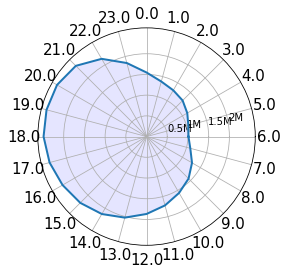

In [8]:
def cool_ticks(value, tick_number=None):
    '''based on https://stackoverflow.com/a/59973033/9419492'''
    num_thousands = 0 if abs(value) < 1000 else floor(ceil(log10(abs(value)))/3)
    value = round(value / 1000**num_thousands, 1) 
    return f'{value:g}'+' KMGTPEZY'[num_thousands], value * 1000**num_thousands

def clock_graph(hours: pd.Series, labels:list=None):
    '''plots a Series in a Radar Chart.
        :hours: a pandas series where each row index will become an angle
    '''
    # https://www.python-graph-gallery.com/390-basic-radar-chart
    N = len(hours)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    hours = pd.concat([
        hours.iloc[-N//4-1:],
        hours.iloc[:-N//4-1] ]) if N==24 else hours.sort_index(ascending=False)
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels
    labels = labels if labels is not None else hours.index
    plt.xticks(angles[:-1], labels, color='black', size=15)

    # Draw ylabels
    ax.set_rlabel_position(10)
    M = hours.max()
    ticks = [cool_ticks(M*x/5) for x in range(1,5)]
    plt.yticks([v[1] for v in ticks], [t[0] for t in ticks], color="black", size=10)
    plt.ylim(0,M*21/20)
    
    # Plot data
    ax.plot(angles, [*hours, hours.iloc[0]], linewidth=2, linestyle='solid')

    # Fill area
    ax.fill(angles[:-1], hours, 'b', alpha=0.1)

hours = time.hour.value_counts(sort=False).sort_index(ascending=False).to_frame()

clock_graph(hours.hour)

#### $\bullet$ Create a function that receives a time intervals list as a parameter and returns a plot with the number of posts for each given interval.

In [9]:
def inter(h, inters, categories):
    assert len(inters)-1 == len(categories), 'Categories and Intervals length must match'
    assert inters[0] == 0 and inters[-1]==24, 'Intervals list must start at 0 and end at 24'
    for i in range(len(inters) - 1):
        if h >= inters[i] and h < inters[i+1]:
            return categories[i]
        
def plot_intervals(hours_count, inters=range(0,25,4), col_name='hour'):
    """A radarplot with the hours divided into intervals
    :hours_count: a dataframe where index is the hours
    :inters: a sorted list of hours breakpoints, starting at 1 and ending at 24
    :col_name: the column of which the values have to be plotted
    """
    I = pd.CategoricalDtype(categories= [f"{inters[i]}:00->{inters[i+1]-1}:59" for i in range(len(inters)-1)], ordered=True)
    hours_count['intervals'] = hours_count.index.to_series().apply(
        lambda h :inter(h, inters, I.categories)
    ).astype(I)
    clock_graph(hours_count.groupby(by='intervals').sum()[col_name])

#### $\bullet$ Use the function that you created in the previous literal to plot the number of posts between the following time intervals:

| Initial time | Final time |
|---|---|
| 06:00:00 | 10:59:59 |
| 11:00:00 | 13:59:59 |
| 14:00:00 | 16:59:59 |
| 17:00:00 | 19:59:59 |
| 20:00:00 | 23:59:59 |
| 00:00:00 | 02:59:59 |
| 03:00:00 | 05:59:59 |

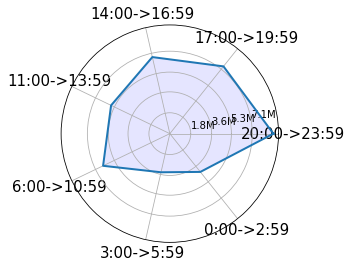

In [10]:
INTERVALS = [0,3,6,11,14,17,20,24]
plot_intervals(hours, INTERVALS)

In [11]:
del time
del hours

***

### 4. __[RQ4] In most cases, we will not have a consistent dataset, and the one we are dealing with is not an exception (ex. in the given datasets, you may not find the information of the profiles for some of the posts). So let’s enhance our analysis.__

***

#### $\bullet$ Write a function that, given a profile_id, will be able to return the posts that belong to the given profile_id.

In [37]:
sub_posts = posts.col(['profile_id', 'post_id', 'numbr_likes', 'number_comments']) 

In [38]:
def post_finder(prof_id):
    # the function will return a subset containing only the rows with profile_id equal to the query  
    return sub_posts[sub_posts["profile_id"] == prof_id]

In [39]:
# let's try the function with an example profile_id
example = 5337907015
post_finder(example)

,post_id,profile_id,numbr_likes,number_comments
sid,,,,
28452667,BsRarTBBPmd,5337907015,30,6
28452668,BqOlb0kBQ5V,5337907015,25,5
28452669,BtxQHmLhI1h,5337907015,26,11
28452670,BxDLnoAhLJL,5337907015,24,3
28452671,BvFHZuWBcy2,5337907015,23,5
28452672,Bic19O-liDj,5337907015,28,0
28452673,BsTLZELBTnU,5337907015,28,0
28452674,BqTsJM_FDQ_,5337907015,28,0
28452675,ByB_OFnnGFM,5337907015,19,0


#### $\bullet$ Write another function that, given an input n (an integer), will return the posts that belong to the n top posted profiles (top n profiles that have posted the highest number of posts) that their data is available in the profile.csv using the previously written function.

In [40]:
sub_profiles = profiles.col(['profile_id', 'n_posts'])

In [41]:
def top_posts_profiles(n):
    # find the n profiles who post the most using profiles dataset
    top10_profiles = sub_profiles.nlargest(n, 'n_posts')
    # search and return all the posts that belongs to "prof"
    return sub_posts.loc[sub_posts['profile_id'].isin(top10_profiles['profile_id']), 
                         ["profile_id", "post_id", "numbr_likes", "number_comments"]]

In [42]:
example = 3
top_posts_profiles(example)

,profile_id,post_id,numbr_likes,number_comments
sid,,,,
8768851,199664772,3V4OeXypTT,19,0
9253732,8563366588,BxJp4i3pArJ,0,0
9253733,8563366588,BxJp2qgpVJo,0,0
9253736,8563366588,BxJpzW4J6Aq,0,0
9253737,8563366588,BxJpxSLp4rB,0,0
...,...,...,...,...
39883139,1273455368,Bz6mAlXpyCK,3,0
39883141,1273455368,Bz6l-HkpF8G,2,0
39883143,1273455368,Bz6lo6RpKQF,2,0


#### $\bullet$ What is the average number of "likes" and comments of the top 10 profiles with the highest number of posts which their information is available in profile.csv?

In [43]:
# through the previously created function it finds all the posts of the 10 users who post the most 
# with the associated number of likes and comments
top10 = top_posts_profiles(10)
# groups by profile_id and calculates the average of the number of likes their posts have got
round(top10[['profile_id', 'numbr_likes']].groupby('profile_id').mean(), 2)

,numbr_likes
profile_id,
9813508,0.3
199664772,7.67
218172998,0.4
285549744,3.92
1087613619,2.03
1273455368,2.96
1603889832,6.48
1607309412,1.54
8563366588,0.0


In [44]:
# groups by profile_id and calculates the average of the number of comments their posts have got
round(top10[['profile_id', 'number_comments']].groupby('profile_id').mean(), 2)

,number_comments
profile_id,
9813508,0.0
199664772,0.0
218172998,0.04
285549744,0.0
1087613619,0.18
1273455368,0.04
1603889832,0.04
1607309412,0.0
8563366588,0.0


In [45]:
del sub_posts, sub_profiles

#### $\bullet$ Plot the number of posts that these top 10 profiles have sent on Instagram in the given interval in question RQ3. Interpret the resulting chart.

In [46]:
# slightly modified version of the function created in step 3
def inter_v2(h, inters):
    assert inters[0] == 0 and inters[-1]==24, 'Intervals list must start at 0 and end at 24'
    for i in range(len(inters) - 1):
        if h >= inters[i] and h < inters[i+1]:
            return i

In [47]:
# create a new subset that contains only profile_id and cts
posts_cts = posts.col(['profile_id', 'cts'], index=False)
# keep only the rows in which a profile_id belonging to the top 10 appears
posts_cts = posts_cts[posts_cts["profile_id"].isin(top10['profile_id'].value_counts().index.tolist())]
# add a column called hour in the same way of exercise 3
posts_cts['hour'] = posts_cts['cts'].map(lambda x: x.hour).astype('Int8')
# add a column called intervals in the same way of exercise 3
posts_cts['intervals'] = posts_cts['hour'].map(lambda h :inter_v2(h, [0,3,6,11,14,17,20,24]))

In [48]:
# for each user of the top 10 it counts how many posts he made in each of the established time intervals
prof_posts_hour = pd.crosstab(posts_cts.profile_id, posts_cts.intervals).replace(0,np.nan).\
     stack().reset_index().rename(columns={0:'Time'})

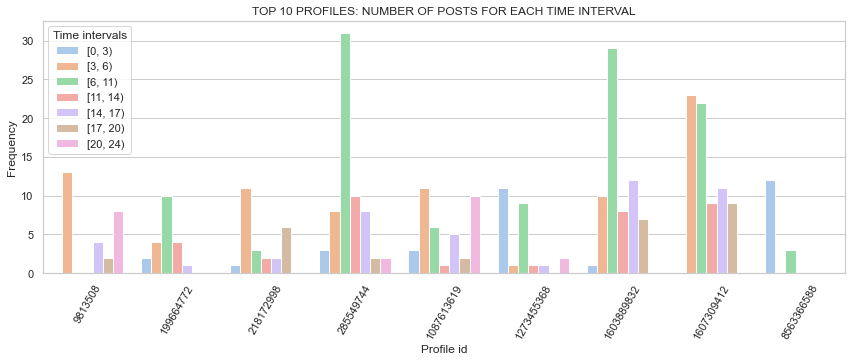

In [49]:
plt.figure(1, figsize=(12, 5))

labels=["[0, 3)","[3, 6)", "[6, 11)", "[11, 14)", "[14, 17)", "[17, 20)", "[20, 24)"]
ax = sns.barplot(data=prof_posts_hour, x="profile_id", y="Time", hue="intervals", palette="pastel")
plt.xticks(rotation=60)
plt.tight_layout()
plt.title("TOP 10 PROFILES: NUMBER OF POSTS FOR EACH TIME INTERVAL")
plt.xlabel("Profile id")
plt.ylabel("Frequency")
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="Time intervals", loc='upper left')
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme(style="whitegrid")
plt.show()

In [50]:
del posts_cts, prof_posts_hour, top10

***

### 5. __[RQ5] The most influential users are the ones with the highest number of “followers", you can now look more into their activity.__

***

#### $\bullet$ Plot the top 10 most popular users in terms of followers and their number of posts.

In [51]:
# create a new subset that contains only profile_id and cts
subset5 = profiles.col(['profile_name', 'followers', 'n_posts']).dropna()

In [52]:
# extract only the 10 users with the highest number of followers
top10profiles_followers = subset5.nlargest(10, 'followers')

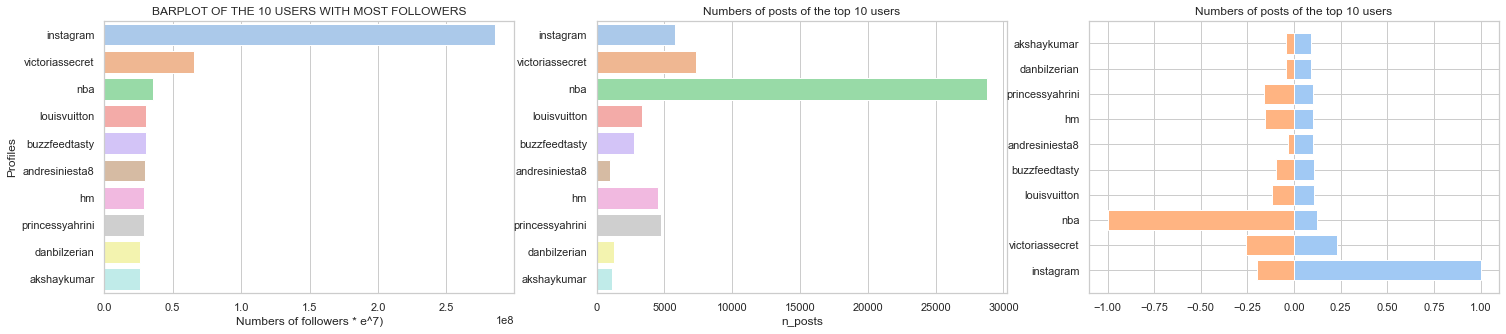

In [53]:
plt.figure(1, figsize=(25, 5))

plt.subplot(1, 3, 1)
sns.barplot(data=top10profiles_followers, x='followers', y='profile_name', palette="pastel")
plt.title("BARPLOT OF THE 10 USERS WITH MOST FOLLOWERS")
plt.ylabel("Profiles")
plt.xlabel("Numbers of followers * e^7)")
#plt.grid()

plt.subplot(1, 3, 2)
sns.barplot(data=top10profiles_followers, x='n_posts', y='profile_name', palette="pastel")
plt.ylabel('')
plt.title('Numbers of posts of the top 10 users')

plt.subplot(1, 3, 3)
top10profiles_followers['followers'] = top10profiles_followers['followers']/top10profiles_followers['followers'].max()
top10profiles_followers['n_posts'] = top10profiles_followers['n_posts']/top10profiles_followers['n_posts'].max()
color1 = sns.color_palette("pastel")[0]
color2 = sns.color_palette("pastel")[1]
plt.barh(top10profiles_followers['profile_name'], top10profiles_followers['followers'], 
         align='center', color=color1)
plt.barh(top10profiles_followers['profile_name'], -top10profiles_followers['n_posts'], 
         align='center', color=color2)
plt.title('Numbers of posts of the top 10 users')

plt.show()

#### $\bullet$ Who is the most influential user?

In [54]:
top10profiles_followers[['profile_name']].head(1)

,profile_name
sid,
336492,instagram


The most influential user is the one with the most followers, so it's Instagram 

#### $\bullet$ Have they posted anything with tagged locations? Extract the most frequent areas on their posts and plot the number of times each city has been visited.

In [55]:
# subset with only the needed columns of dataset posts
post_locations = posts.col(['sid_profile', 'location_id', 'post_type']).dropna()

In [56]:
# check for every influent user if they have tagged any location in a post
post_locations_influent = post_locations.loc[post_locations['sid_profile'].isin(top10profiles_followers.index), 
                                             ['sid_profile', 'location_id']]
print(top10profiles_followers.index.isin(post_locations_influent['sid_profile']))

[ True  True  True  True  True  True  True  True  True  True]


All of them has at least one post with a tagged location

In [57]:
# subset with only the needed columns of dataset locations
locations_city = locations.col(['id', 'city'])

In [58]:
# to find the cities most visited (it will takes the first ten)
top_city = locations_city.loc[locations_city['id'].isin(post_locations_influent['location_id'])].city.value_counts().head(10)
# we eliminate one of the location because it has no name
top_city = top_city[top_city.index != '']

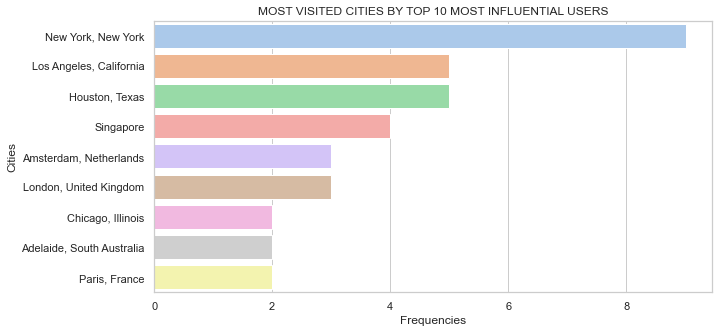

In [59]:
plt.figure(1, figsize=(10, 5))
sns.barplot(x=top_city, y=top_city.index, palette='pastel')
plt.xlabel('Frequencies')
plt.ylabel('Cities')
plt.title('MOST VISITED CITIES BY TOP 10 MOST INFLUENTIAL USERS')
plt.show()

#### $\bullet$ How many pictures-only posts have they published? How many reels? (only videos) and how many with both contents? Provide the number as percentages and interpret those figures.

#### $\bullet$ How many "likes" and comments did posts with only pictures receive? How about videos and mixed posts? Try to provide the average numbers and confront them with their followers amount, explaining what you can say from that comparison.

In [60]:
del subset5, top10profiles_followers, post_locations, post_locations_influent, locations_city, top_city

### 6. __[RQ6] It's time to get information from the user posting effectiveness.__

#### What is the average time (days and minutes) a user lets pass before publishing another post? Plot the top 3 users that publish posts more frequently (calculate the average time that passes between posts), including their amount of followers and following. Provide insights from that chart.

In [131]:
# TODO maybe it's better to load 
    # 'sid_profile' since it's of int type and can be connected to profiles table
    # 'profile_id' since it includes all profiles id (less null?) and otherwise most of the values get smashed into -1
drift = lambda g: (g.max() - g.min()) / (g.count()-1) if g.shape[0] > 1 else pd.NA

post_time = posts\
                .col(['profile_id','sid_profile','cts'], index=None)\
                .groupby(by=['profile_id','sid_profile'], sort=False, dropna=True)\
                .aggregate(
                        drift=pd.NamedAgg(column="cts", aggfunc=drift),
                        count=pd.NamedAgg(column="cts", aggfunc="count"))\
                .dropna()
post_time = post_time[post_time.index.get_level_values('sid_profile') != -1]
post_time['drift'] = post_time['drift'].astype('timedelta64[ns]')
post_time.head()

,,drift,count
profile_id,sid_profile,,
2237947779,3496776,17 days 10:03:56.027027,38
11771599,3303402,79 days 09:58:46.133333,16
6027750611,3406435,2 days 02:45:14.545454,12
6263700119,3529017,3 days 18:16:18.687500,17
2873605885,3206132,124 days 00:16:34.333333,4


We want to note that this kind of metric, as taken by itself alone, has **little or no value** since it doesn't take in account the number of posts, and it's not robust at all.

For example it could happen that people that have posted only a couple of times in a small interval of time are labeled as the most frequent post publishers.

In [132]:
N3 = 3 # 100
post_time = post_time[
    (post_time.index.get_level_values('sid_profile') != -1) &\
    (post_time['drift'] > pd.Timedelta(minutes=1)) # if a post occurs before in under 1 minute from another post is probably a double counting issue or repost 
]
top3 =  post_time.nsmallest(N3*10, columns=['drift'])

top3 = pd.concat([
    top3.droplevel('profile_id'),
    profiles.col(['followers', 'following'], index=True).dropna()
], axis=1, join='inner')
top3.head(N3)

,drift,count,following,followers
520414,0 days 00:01:00.090909,12,147,111
1296750,0 days 00:01:00.090909,12,1598,891
2795357,0 days 00:01:00.090909,12,7587,2798


Here I plot on a graph the first 3 top frequency post publishers (excluding those that do not have a following/followers infos)

I honestly do not get any insight from this graph because:
- 3 isn't enough to get any useful insights
- this frequency measure we're taking in is not robust at all, and shouldn't be considered into account (for the aforementioned reasons)
- even when plotting much more points, the plot doesn't show any correlation between drift and the other two features
- some of the elements have $T = 0$, meaning that it may have happened that some posts have been posted in the exact same moment by the same account $frequency = \frac{1}{T} = \infty$

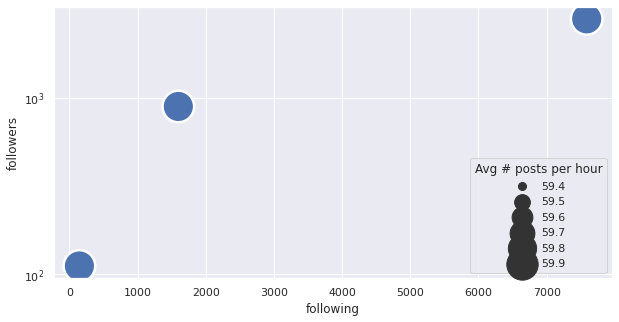

In [133]:
ax = sns.scatterplot(data=top3.iloc[:N3],
                x="following", 
                y="followers", 
                size=3600/top3['drift'].dt.total_seconds(), 
                sizes=(10,1000),
                palette="pastel")
ax.legend(title='Avg # posts per hour')
ax.set_yscale('log')
plt.show()

In [ ]:
del top3 
del post_time

#### Using the function you previously coded, plot the time intervals with the highest average number of “likes” and the ones with the highest average number of comments on posts.

In [134]:
likes_time = posts.col(['numbr_likes', 'number_comments', 'cts'], index=False)
likes_time['hour'] = likes_time['cts'].dt.hour
likes_time.drop('cts', inplace=True, axis=1)

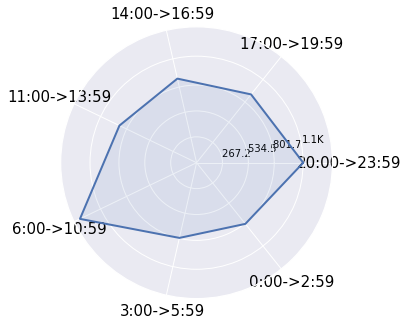

In [135]:
plot_intervals(likes_time.groupby(by='hour').agg('mean'), INTERVALS, col_name='numbr_likes')

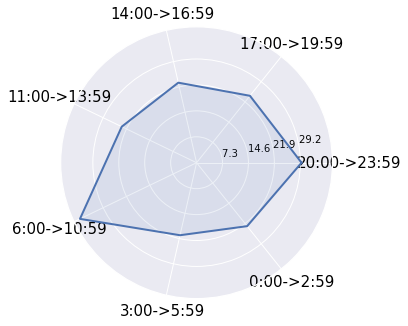

In [136]:
plot_intervals(likes_time.groupby(by='hour').agg('mean'), INTERVALS, col_name='number_comments')

In [ ]:
del likes_time

#### 7. __[RQ7] Of course, calculating probabilities is a job that any Data Scientist must know. So let's compute some engaging figures__

#### $\bullet$ What's the probability that a post receives more than 20% "likes" of the number of followers a user has?

In [68]:
# First we create a subset of the posts dataframe that contains only the columns that we need
# and the rows for which we have a match (with the user) in the profiles dataset
sub_posts = posts.col(["sid_profile", "numbr_likes"])
sub_posts = sub_posts[sub_posts['sid_profile'] != -1]

In [69]:
# We create also a subset for the profiles dataset which contain only "sid" and "followers" 
# and the rows different from NA
sub_prof = profiles.col(["followers"]).dropna()

In [70]:
# At this point we merge the to subsets on "sid_profile"
merged_df = pd.merge(sub_posts, sub_prof, left_on="sid_profile", right_on=sub_prof.index)

In [ ]:
# Then we can calculate the numbers of positive cases
pos_cases = (merged_df.apply(lambda x: x.numbr_likes > x.followers*0.2, axis=1)).sum()
# And finally we calculate the probability dividing the positive cases for the total number of evaluated posts
print(f"Probability is equal to: {round(pos_cases/merged_df.shape[0], 5)*100}%")

In [ ]:
del sub_posts, sub_prof, merged_df, pos_cases

#### $\bullet$ Do users usually return to locations? Extract the probability that a user returns to a site after having posted it in the past. Does that probability make sense to you? Explain why or why not.

In [14]:
# Subset that contains only the necessary columns of posts dataset
posts_loc = posts.col(["profile_id", "location_id"])

In [15]:
# Then we eliminate the rows that do not contain duplicates in the values of the two columns
posts_loc2 = posts_loc[posts_loc.duplicated(subset=["profile_id", "location_id"], keep=False)]
# As a last step we eliminate the duplicates and take the value of the number of rows left
n_duplicates = posts_loc2.drop_duplicates(subset=["profile_id", "location_id"]).shape[0]
# We are now ready to calculate the probability...
# Case 1: considering as denominator the number of total different users:
prob_dupl1 = n_duplicates / posts_loc.nunique()[0]
# Case 2: considering as denominator the number of total different couple user-location:
prob_dupl2 = n_duplicates / posts_loc.groupby(["profile_id", "location_id"]).ngroups
print(f"Probability that a user returns to a site after having posted it in the past is equal to: {round(prob_dupl1,4)*100}%")
print(f"Probability that a user returns to a site after having posted it in the past is equal to: {round(prob_dupl2,4)*100}%")

Probability that a user returns to a site after having posted it in the past is equal to: 38.36%
Probability that a user returns to a site after having posted it in the past is equal to: 21.52%


In [13]:
del posts_loc, posts_loc2, n_duplicates

### 8. __[RQ8] Every decision you take in a data-based environment should be reinforced with charts, statistical tests and analysis methods to check whether a hypothesis is correct or not.__

#### $\bullet$ Does more “likes” also mean more comments? Plot a scatter plot of “likes” vs comments for posts.

In [7]:
# create a subset with only the necessaries columns of posts dataset
sub8_posts = posts.col(['post_id', 'numbr_likes', 'number_comments', 'cts'], index=False).dropna()

In [11]:
# to check if there is a correlation between the number of likes and the number of comments
test_likes_vs_comments = pearsonr(sub8_posts['numbr_likes'], sub8_posts['number_comments'])
test_likes_vs_comments

(0.37445351725562276, 0.0)

Through the pearson correlation index we calculate the correlation between the two variables, we find that they are positively correlated. To test whether this correlation is statistically significant or not, we calculate the p-value which, being <0.05, confirms that the correlation is statistically significant.

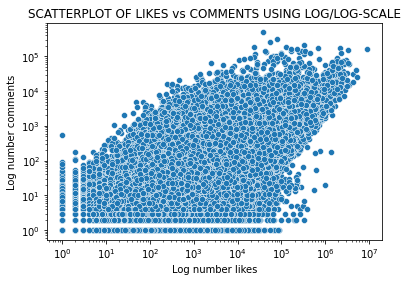

In [12]:
# To visualize the scatterplot it is useful to apply a logorithmic transformation both 
# to the values of the likes column and to the values of the comments column. 
# This transformation is used when the range of natural scales is too wide and there are 
# "extreme" values that make it impossible to display the graph correctly.
plt.figure(1, figsize=(10, 5))
scatter_plot = sns.scatterplot(data=sub8_posts, x="numbr_likes", y="number_comments")
scatter_plot.set(xscale="log", yscale="log")
plt.xlabel("Log number likes")
plt.ylabel("Log number comments")
plt.title("SCATTERPLOT OF LIKES vs COMMENTS USING LOG/LOG-SCALE")
plt.show()

#### $\bullet$ Can you find any significant relationship between the time a user publishes a post and the number of comments and “likes”? Use an appropriate statistical test or technique and support your choice.

#### $\bullet$ What’s the distribution of followers? Plot the empirical distribution of followers amongst all users and extract the mean, mode, and quantiles. Interpret those figures.

In [ ]:
# First we create a subset wich contains only the number of followers
profiles_followers = profiles.col(['followers'], index=False, nrows=SAMPLE_SIZE)
# Then we can drop all the NA because we don't need them to visualize the empirical distribution
profiles_followers.dropna(inplace=True)
# As a last step we apply the logaritm to the followers because the range is too big and otherwise would be impossible 
# to visualize them correctly. We use log(x+1) to avoid that profiles with 0 followers will result -inf
prof_foll_log = profiles_followers['followers'].apply(lambda x: np.log(x+1))

In [ ]:
sns.histplot(prof_foll_log, bins=100, kde=True)
plt.xlabel("Log(followers + 1)")
plt.ylabel("Frequency")
plt.title("HISTOGRAM OF THE FOLLOWERS DISTRIBUTION USING LOG-SCALE")
plt.show()

In [ ]:
# followers mean
followers_mean = round(np.mean(profiles_followers['followers']), 3)
print(f'Followers mean is equal to: {followers_mean}')
# followers mode
followers_mode = round(statistics.mode(profiles_followers['followers']), 3)
print(f'Followers mode is equal to: {followers_mode}')
# followers first quartile
followers_1stQuantile = int(np.quantile(profiles_followers['followers'], q=0.25))
print(f'Followers first quartile is equal to: {followers_1stQuantile}')
# followers median
followers_median = int(np.quantile(profiles_followers['followers'], q=0.5))
print(f'Followers median is equal to: {followers_median}')
# followers third quartile
followers_3rdQuantile = int(np.quantile(profiles_followers['followers'], q=0.75))
print(f'Followers third quartile is equal to: {followers_3rdQuantile}')

#### $\bullet$ What are histograms, bar plots, scatterplots and pie charts used for?

Histograms, bar plots, scatterplots and pie charts are the most popular and used tools for data visualization.

* **Histograms** are used to represent continuous variables divided into a series of intervals. These intervals must be adjacent and they can be also of different sizes. They are also useful when dealing with large datasets because they can help in detecting any unusual observations (outliers) or any gaps in the data. Each bin (interval) is repreesented by a rectangle. If the bins have the same size, the height of the rectangle is proportional to the frequency (the number of cases in each interval), otherwise the *area* of the rectangle has to be proportional to the frequency. In this last case, the height represent the *frequency density* (the number of cases per unit of the variable on the x-axis). A histogram has an appearance similar to a vertical bar chart, but there are no gaps between the bars. Generally, a histogram will have bars of equal width. 

* **Bar plots** are used to compare categorical data with rectangular bars with heights or lengths proportional to the values that they represent. The bars can be plotted vertically or horizontally. A bar plot shows comparisons among discrete categories. One axis of the chart shows the specific categories being compared, and the other axis represents a measured value. They can also represent bars clustered in groups of more than one, showing the values of more than one measured variable.

* **Scatterplots** are a type of plot or mathematical diagram used to represent values for (usually) two variables in a Cartesian diagram. The data are displayed as a collection of points, each having the value of one variable determining the position on the horizontal axis and the value of the other variable determining the position on the vertical axis. With a scatterplot can be detected relations and correlations between variables. They can be used for both continuous and discrete variables.

* **Pie charts** are circular statistical graphics. The 'pie' is divided into slices proportional to the quantity they represent. They are suited to express percentage and to observe the composition of a phenomenon. The total sum of the percentages must be equal to 100%. If there are a lot of modalities related to the phenomenon we want to represent it can be worth to use a bar plot, because comparing the area of a lot of 'slices' can be not so easy.

#### $\bullet$ What insights can you extract from a Box Plot?

**Box plots** provide a quick visual summary of the variability of values in a dataset. They help to identify the first quartile (as the lower box edge), the median (as the line inside the box) and the third quartile (as the upper box edge). In the box plots can be shown also lines representing the values located outside lower and upper quartiles. Outliers can reveal mistakes or unusual occurrences in data, and can be represented by single points. A box plot is created using a number or rate/ratio field on the y-axis.

In addition, it can be known the variability and the dispersion of the variable, looking at the length of the box. If the box is little, all the data is located near to the median, meaning that there's low dispersion; otherwise the result is a larger box. This type of plot can give also information about the symmetry of a variable. If the median line is in the center of the box, maybe the variable is symmetric (but is always needed to check it also with statistical parameters), otherwise the line will be closer to one box edge (quartile) than the other.

Box plots are useful to answer questions like: How is my data distributed? Are there any outliers in the dataset? 

| Component | Description |
|---|---|
| Whisker | The range of data less than the first quartile and greater than the third quartile. Each whisker has 25 percent of the data. Whiskers typically cannot be more than 1.5 times IQR, which sets the threshold for outliers. |
| Box | The range of data between the first and third quartiles. 50 percent of the data lies within this range. The range between the first and third quartile is also known as the Inter Quartile Range (IQR). |
| Maximum | The largest value in the dataset or the largest value that is not outside the threshold set by the whiskers. |
| Third quartile | The value where 75 percent of the data is less than the value, and 25 percent of the data is greater than the value. |
| Median | The middle number in the dataset. Half of the numbers are greater than the median and half are less than the median. The median can also be called the second quartile. |
| First quartile | The value where 25 percent of the data is less than the value, and 75 percent of the data is greater than the value. |
| Minimum| The smallest value in the dataset or the smallest value that is not outside the threshold set by the whiskers. |
| Outliers| Data values that are higher or lower than the limits set by the whiskers. |

***

## __Bonus points__

***

#### Up to this point, you probably have worked with one or two files simultaneously. Nevertheless, for the literals a. and b. of this section, you must work with the three datasets at the same time. Note that performing some of these operations might be too complex for your pc specs. For this reason, we suggest you make use of AWS (yeah! only a suggestion). In case you need it, in the following links you can find the same three files already mounted into AWS for you to work with them easily (instagram_posts, instagram_profiles, instagram_locations).

#### a. Sort the users in terms of number of followers and divide them into two groups: for the first group, take only the top 10% regarding "followers", and for the second one, take the rest. Now compare the mean of time intervals between posts for the two categories. Do you notice something relevant?

In [ ]:
profiles.df = profiles.col(['followers'], index=True).dropna()
profiles.df.head()

,followers
sid,
4184446,146
4184457,1145
4184460,324
4184465,192
4184471,4137


In [ ]:
drift = lambda g: (g.max() - g.min()) / (g.count()-1) if g.shape[0] > 1 else pd.NA

post_time = posts\
                .col(['sid_profile','cts'], index=None)\
                .groupby(by=['sid_profile'], sort=False, dropna=True)\
                .agg(drift=pd.NamedAgg(column="cts", aggfunc=drift))\
                .dropna()
post_time = post_time[post_time.index.get_level_values('sid_profile') != -1]
post_time['drift'] = post_time['drift'].astype('timedelta64[ns]')
post_time.head()

,drift
sid_profile,
3496776,17 days 10:03:56.027027
3303402,79 days 09:58:46.133333
3406435,2 days 02:45:14.545454
3529017,3 days 18:16:18.687500
3206132,124 days 00:16:34.333333


In [ ]:
profiles.df = pd.concat([
    post_time,
    profiles.df[['followers']]
], axis=1, join='inner')
profiles.df.head()

,drift,followers
1817101,5 days 14:09:50.187500,858
3521482,20 days 12:59:05.047619,5099
1891211,80 days 13:46:52.250000,559
4293767,22 days 22:59:48.409090,926
3414742,125 days 21:28:32.812500,4161


In [ ]:
profiles.df['category'] = pd.qcut(profiles.df.followers, [0.,0.9,1.], labels=['norm', 'influencer'])

print('Influencers mean time between posts: \t', profiles.df[profiles.df.category=='influencer'].drift.mean())
print('Normal users mean time between posts: \t', profiles.df[profiles.df.category=='norm'].drift.mean())

Influencers mean time between posts: 	 10 days 14:46:14.786765333
Normal users mean time between posts: 	 23 days 09:13:00.539863666


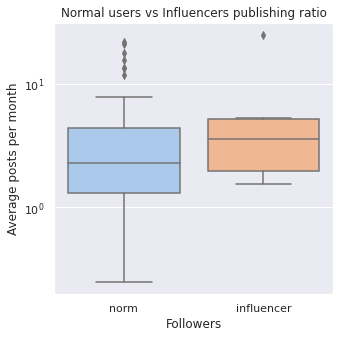

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})

ax = sns.boxplot(data=profiles.df, 
            x='category', 
            y=24*31*3600/profiles.df['drift'].dt.total_seconds(), 
            palette='pastel')
ax.set(
    xlabel = 'Followers',
    ylabel = 'Average posts per month',
    title = 'Normal users vs Influencers publishing ratio',
    yscale = 'log')
plt.show()

In [ ]:
del post_time
del profiles.df

#### b. Assume users publish their posts the same day pictures or videos are taken: Are there users that have visited the same location on the same day? How about the same week? Extract the results and explain them.

In [ ]:
posts.df = posts\
    .col(['location_id', 'profile_id', 'cts'])\
    .dropna()

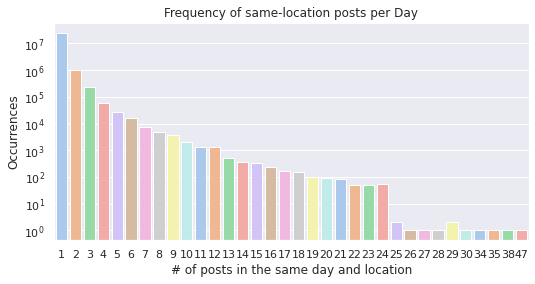

In [ ]:
day = posts.df\
            .groupby([pd.Grouper(key="cts", freq="1d"), 'location_id', 'profile_id'], sort=False)\
            .agg(cnt=pd.NamedAgg(column="cts", aggfunc='count'))['cnt']\
            .value_counts().sort_index()
sns.set(rc={'figure.figsize':(day.index.shape[0]/4,4)})
ax = sns.barplot(x=day.index, y=day, palette='pastel')
ax.set(
    xlabel = '# of posts in the same day and location',
    ylabel = 'Occurrences',
    title = 'Frequency of same-location posts per Day',
    yscale = 'log'
)
plt.show()

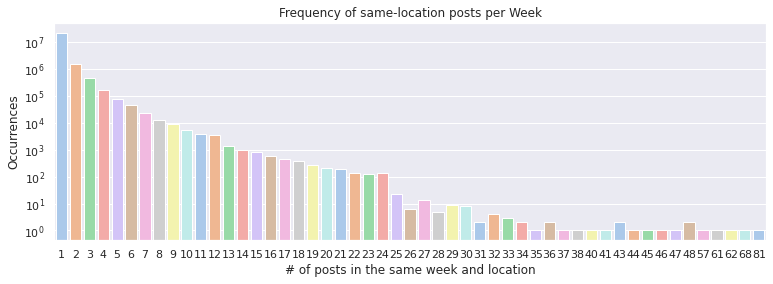

In [ ]:
week = posts.df\
            .groupby([pd.Grouper(key="cts", freq="1W"), 'location_id', 'profile_id'], sort=False)\
            .agg(cnt=pd.NamedAgg(column="cts", aggfunc='count'))['cnt']\
            .value_counts().sort_index()
sns.set(rc={'figure.figsize':(week.index.shape[0]/4,4)})
ax = sns.barplot(x=week.index, y=week, palette='pastel')
ax.set(
    xlabel = '# of posts in the same week and location',
    ylabel = 'Occurrences',
    title = 'Frequency of same-location posts per Week',
    yscale = 'log'
)
plt.show()

In [ ]:
del posts.df

#### c. Implement a text data analysis (also known as text mining) of the field "description" from instagram_posts.csv for descriptions written in English. Use appropriate visualizations and statistics to highlight the words (and probably the topics) provided for the users in that field.

***

## __Command Line Question__

***

#### Using the command line is a feature that Data Scientists must master. It is relevant since the operations there require less memory to use in comparison to other interfaces. It also does not use as much CPU processing time as other interfaces. In addition, it can be faster and more efficient and handle repetitive tasks quickly.

#### In this question, you should use command line tools such as grep and possibly other commands to answer the following question:

#### $\bullet$ Using the instagram_posts.csv, retrieve the first ten posts with descriptions longer than 100 characters and output the profiles that posted them. (Please keep in mind that the profile associated with some of those posts may not be found in the profiles. You can simply output User was not found! for those posts.)

#### Note: You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable.

***

## __Algorithmic Question__

***

### 1. __[AQ1] Given the following pseudocode, answer the questions:__

```
Input:
       N : an integer
       List : array of characters of length N

function f1(sequence, end):
    For i=0 To end:
        OUTPUT sequence[i]
    EndFor
        Output "\n"

function f2(sequence, start, end):
    If start = end:
        f1(sequence, end)
    Else
        For i=start To end:
            temp <-- sequence[start]
            sequence[start] <-- sequen
            sequence[i] <-- temp
            f2(sequence, start+1, end)
            temp <-- sequence[start]
            sequence[start] <-- sequen
            sequence[i] <-- temp

f2(List, 0, N)
```

####  What is the output of this algorithm? Describe the mechanism of the algorithm in detail . We do not want to know only its final result. (Describe one example on your own)

This algorithm performs consecutives swaps of items in the array in order to obtain and print all the possible permutations of the initial array of characters.
At each call of $f2$, starting from a certain parameter $i_{start}=0$, the function iterates in the set $\{i | i_{start} \leq i \leq N, i \in \N\}$ of $i$, each time swapping the char in position $i_{start}$ with the one in $i$, and then calling itself with parameter $i_{start}' = i_{start} + 1$. After this new call of $f2$ has ended, it swaps back $i_{start}$ and $i$, and proceeds to repeat the process for the next $i$. 

When $i_{start} = N$ the function prints the current state of the char array, through the $f1$ function.

The result is that all the possible permutations are printed, and the char array is left ordered at the end.

```
0:0	 a<>a	 ['a', 'p', 'e']
1:1	 p<>p	 ['a', 'p', 'e']
2:2	 e<>e	 ['a', 'p', 'e']
OUTPUT	ape
2:2	 e<>e	 ['a', 'p', 'e']
1:1	 p<>p	 ['a', 'p', 'e']
1:2	 p<>e	 ['a', 'p', 'e']
2:2	 p<>p	 ['a', 'e', 'p']
OUTPUT	aep
2:2	 p<>p	 ['a', 'e', 'p']
1:2	 e<>p	 ['a', 'e', 'p']
0:0	 a<>a	 ['a', 'p', 'e']
0:1	 a<>p	 ['a', 'p', 'e']
1:1	 a<>a	 ['p', 'a', 'e']
2:2	 e<>e	 ['p', 'a', 'e']
OUTPUT	pae
...
```



#### $\bullet$ What is asymptotically (i.e., we are asking for big-O complexity) the algorithm's running time as a function of N?

At any call of $f2(i_{start})$ it performs $2(N - i_{start})$ swaps, calling $N - i_{start}$ times $f2(i_{start} - 1)$. So each function call calls another function $N - i_{start}$ times:
$$
    T(n) = 2n + n \cdot T(n-1) 
$$
$$
    T(N) = 2N + N(2(N-1) \cdot (N-1)(...)) = O(N^2 \cdot N!) \overset{Stirling}{=}O(N^(N+2))
$$

#### $\bullet$ Is this algorithm the optimal one to produce this output? If not, can you suggest a better algorithm to perform the same task?

The algorithm is asymptotically optimal, since no algorithm can produce $N!$ outputs in less then $O(N!)$ complexity.

There is some margin of improvement that can be made 

### 3. __[AQ2] Considering the following problem, answer the questions:__

#### Alex has a ribbon of length N. He wants to cut the ribbon in a way that fulfils the following __three__ conditions:
- Each piece of the cut should have an integer length
- He should at least cut the ribbon once
- The __multiplication__ of the length of all the pieces be the maximum possible

#### 1. Implement a __recursive algorithm__ to help Alex find the maximum possible value after multiplying the length of the pieces. Explain your algorithm in detail.

In [ ]:
def ribbon_cut_exp(N):
    if N <= 2:
        return 1
    l = [N]
    for i in range(1,N//2+1):
        l.append(max(i, ribbon_cut_exp(i)) * max(N-i, ribbon_cut_exp(N-i)))
    return max(l)
                            
ribbon_cut_exp(27)

19683

#### 2. Show that the algorithm has exponential running time.

When the function is called with a certain parameter $N$ the func calls $N-1$ other instances of itself with parameters $\{n | n \in (1,N-1)\}$. Each function has $O(n)$ complexity, since it has to compute $n/2$ products and maximums.

So the number of executions is
$$
    T(n) = O(n) + \sum_i^{n-1} T(i) \geq O(n) + (n-1) \cdot T(1)
$$
$$
    T(N) = O(N) + \sum_i^{N-1}[ O(i) + \sum_j^{i-1}[ O(j) + \sum[ ... ]]]= O(N) + \sum_i^{N-1} 2^i O(i) =\\ (N-2) + 2^1(N-3) + 2^2(N-4) + 2^3(N-5) + ... + 2^N 1 = O(2^N) 
$$

#### 3. Now provide a polynomial solution, based on __dynamic programming__, and compute its running-time complexity.

In [ ]:
def ribbon_cut_poly(N):
    if N <= 2:
        return 1
    cuts = [1,2]
    for x in range(3,N+1):
        l = [x]
        for i in range(1,x//2+1):
            l.append(max(i, cuts[i-1]) * max(x-i, cuts[x-i-1]))
        cuts.append(max(l))
    # print(cuts)
    return cuts[N-1]
    
ribbon_cut_poly(12)

81

At the $j^{th}$ iteration of the outer loop, it iterates $j/2$ times in the inner loop. The inner loop computes some $O(1)$ operations and then appends at the result at a list ($O(1)$). At the end a search for the maximum is performed on an array of length $j/2$, complexity of this last operation is $O(j/2)$.
At the end the total number of operations performed is:
$$
    T(N) = 1 + 2 + ... + (N-1) + N = \frac{N (N-1)}{2} = O(N^2)
$$

#### 4. Evaluate the running time of your algorithm for the sizes (Ns) in the __range of [2, 25]__, plot the results, and interpret it (if you have implemented two algorithms, please include both in the plot and compare them).

In [ ]:
from timeit import timeit

performance = {
    'time' : [],
    'type' : [],
    'N' : []
}
N_RANGE = 26
for i in range(2,N_RANGE):
    print(f"{i}th iteration")
    performance['time'].append(timeit(lambda: ribbon_cut_poly(i), number = 10000) * 10**3)
    performance['type'].append('poly')
    performance['N'].append(i)
    
    performance['N'].append(i)
    performance['time'].append(timeit(lambda: ribbon_cut_exp(i), number=1000) * 10**3)
    performance['type'].append('exp')

2th iteration
3th iteration
4th iteration
5th iteration
6th iteration
7th iteration
8th iteration
9th iteration
10th iteration
11th iteration


<AxesSubplot: xlabel='N', ylabel='time'>

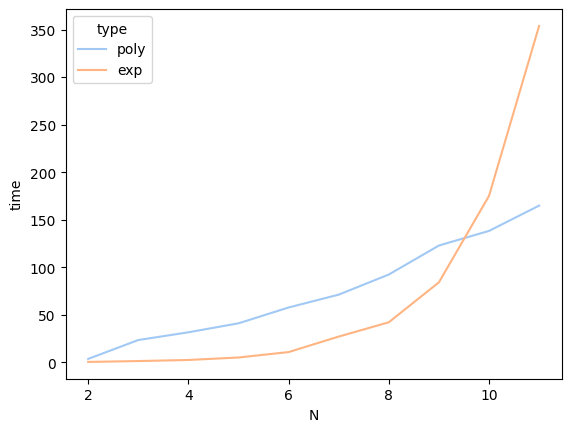

In [ ]:
cut_performance = pd.DataFrame.from_dict(performance)
sns.lineplot(data=cut_performance,x='N', y='time', hue='type', palette='pastel')

#### 5. (Optional, mini bonus) Is the algorithm of question 3 __optimal__? If you belive it, can you prove it? If not, can you find a faster algorithm? In case you found a faster algorithm implement it and explain your algorithm in detail.

The algorithm is not optimal, because the answer can be easily computed by a constant function with complexity $O(1)$

$
f(x) = 
\begin{cases} 
          x & 0 < x \leq 2 \\
          3^{\frac{x}{3}} & x \mod{3} = 0 \\
          2^2 \cdot 3^{\frac{(x-4)}{3}} & x \mod{3} = 1\\
          2 \cdot 3^{\frac{x-2}{3}} & x \mod{3} = 2
       \end{cases}
$


In [ ]:
def ribbon_cut_const(N):
    if N <= 3:
        return N
    if N % 3 == 0:
        return 3** (N // 3)
    if N % 3 == 1:
        return 4 * 3** ((N-4)//3)
    if N % 3 == 2:
        return 3**(N//3) * 2
    
ribbon_cut_const(26)

13122

<AxesSubplot: xlabel='N', ylabel='time'>

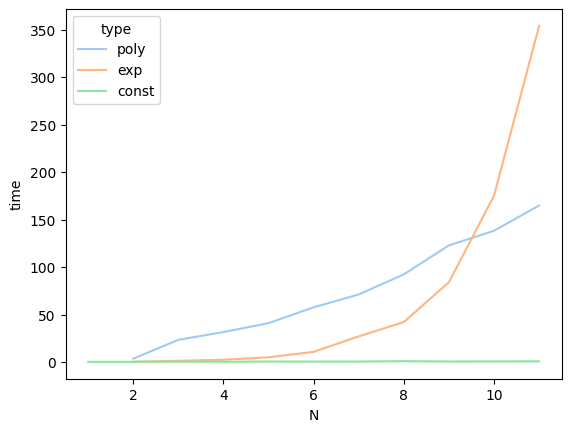

In [ ]:
for i in range(1,N_RANGE):
    performance['N'].append(i)
    performance['time'].append(timeit(lambda: ribbon_cut_const(i), number=1000) * 10**3)
    performance['type'].append('const')
    
cut_performance = pd.DataFrame.from_dict(performance)
sns.lineplot(data=cut_performance,x='N', y='time', hue='type', palette='pastel')